In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

In [2]:
file = "kicking/player_stats_kicking_2021.csv.gz"
df = pd.read_csv(file, compression='gzip', error_bad_lines=False)
df.head(6)
# Note: data is broken down by week for each kicker

,season,week,season_type,team,player_name,player_id,fg_made,fg_missed,fg_blocked,fg_long,fg_att,fg_pct,pat_made,pat_missed,pat_blocked,pat_att,pat_pct,fg_made_distance,fg_missed_distance,fg_blocked_distance,gwfg_att,gwfg_distance,gwfg_made,gwfg_missed,gwfg_blocked,fg_made_0_19,fg_made_20_29,fg_made_30_39,fg_made_40_49,fg_made_50_59,fg_made_60_,fg_missed_0_19,fg_missed_20_29,fg_missed_30_39,fg_missed_40_49,fg_missed_50_59,fg_missed_60_,fg_made_list,fg_missed_list,fg_blocked_list
0,2021,1,REG,ARI,M.Prater,00-0023853,1,1,0,34,2,0.5,5,0,0,5,1.0,34,43,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,34,43,NaN
1,2021,1,REG,ATL,Y.Koo,00-0033702,2,0,0,27,2,1.0,0,0,0,0,NaN,48,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,21;27,NaN,NaN
2,2021,1,REG,BAL,J.Tucker,00-0029597,2,0,0,47,2,1.0,3,0,0,3,1.0,87,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,40;47,NaN,NaN
3,2021,1,REG,BUF,T.Bass,00-0036162,3,0,0,42,3,1.0,1,0,0,1,1.0,104,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,37;25;42,NaN,NaN
4,2021,1,REG,CAR,R.Santoso,00-0034648,2,0,0,29,2,1.0,1,1,0,2,0.5,51,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,22;29,NaN,NaN
5,2021,1,REG,CHI,C.Santos,00-0031203,0,0,0,0,0,NaN,2,0,0,2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


## Functions to correct made_fg_list and missed_fg_list: 
currently ["21;27"] - change to [21, 27]

In [3]:
def correct_made_list(made_list):
    if(str(made_list) == "nan"):
        new_list = []
    else:
        split_list = made_list.split(";")
        new_list = [int(x) for x in split_list]
    return(new_list)

In [4]:
def correct_missed_list(missed_list):
    if(str(missed_list) == "nan"):
        new_list = []
    else:
        split_list = missed_list.split(";")
        new_list = [int(x) for x in split_list]
    return(new_list)

In [5]:
df["fg_made_list"] = df["fg_made_list"].apply(correct_made_list)
df["fg_missed_list"] = df["fg_missed_list"].apply(correct_missed_list)

## Function to calculate season average for field goals from all distances

In [6]:
def calculate_basic_season_average(df):
    made = df["fg_made"].sum()
    missed = df["fg_missed"].sum()
    basic_ave = round(100*made/(made+missed), 1)
    print(f"The overall average for field goals was: {basic_ave}%")
    
    return(basic_ave)

In [7]:
basic_average = calculate_basic_season_average(df)

The overall average for field goals was: 86.4%


## Look at extra point conversion (calculate expected value)

In [8]:
made_xp = df["pat_made"].sum()
attempted_xp = df["pat_att"].sum()
xp_perc = round(made_xp/attempted_xp, 4)
print(f"There were {attempted_xp} attempted extra points and {made_xp} were made for a percent of {round(100*xp_perc,2)}%")

There were 1317 attempted extra points and 1231 were made for a percent of 93.47%


## Function to collect data for each fg distance

In [9]:
def make_fg_by_yard_dict(df):
    # dictionary to hold [attempts, makes] for each distance tried
    fg_dict = {}
    
    # check each row for made ande missed kicks
    for row in range(len(df)):
        made_list = df.loc[row, "fg_made_list"]
        if(len(made_list) > 0):
            # go through each made kick
            for j in range(len(made_list)):
                try: # increase attmpts and makes
                    fg_dict[int(made_list[j])][0] += 1
                    fg_dict[int(made_list[j])][1] += 1
                except: # create key/value for that kick distance
                    fg_dict[int(made_list[j])] = [1,1]
        
        missed_list = df.loc[row, "fg_missed_list"]
        if(len(missed_list) > 0):
            for j in range(len(missed_list)):
                try:
                    fg_dict[int(missed_list[j])][0] += 1
                except:
                    fg_dict[int(missed_list[j])] = [1,0]
        
    return(fg_dict)                    

### Create dictionary and convert to percent, then sort by yards

In [10]:
data_dict = make_fg_by_yard_dict(df)

fg_perc_dict = {}
for key in data_dict:
    attempts = data_dict[key][0]
    made = data_dict[key][1]
    fg_perc_dict[key] = round(100*made/attempts, 2)

sorted_fg_perc_dict = dict(sorted(fg_perc_dict.items(), key=lambda item: item[0]))
print(f"Number of unique yard kicks: {len(sorted_fg_perc_dict)}") #47
sorted_fg_perc_dict

Number of unique yard kicks: 47


{19: 100.0,
 20: 100.0,
 21: 100.0,
 22: 100.0,
 23: 100.0,
 24: 100.0,
 25: 95.65,
 26: 100.0,
 27: 100.0,
 28: 100.0,
 29: 100.0,
 30: 100.0,
 31: 97.3,
 32: 91.3,
 33: 96.3,
 34: 96.88,
 35: 90.62,
 36: 87.18,
 37: 97.06,
 38: 100.0,
 39: 90.32,
 40: 87.1,
 41: 82.14,
 42: 72.41,
 43: 84.62,
 44: 80.77,
 45: 82.14,
 46: 80.49,
 47: 68.0,
 48: 82.93,
 49: 69.57,
 50: 77.78,
 51: 63.33,
 52: 81.08,
 53: 67.65,
 54: 72.22,
 55: 68.42,
 56: 46.15,
 57: 50.0,
 58: 50.0,
 59: 0.0,
 60: 0.0,
 61: 66.67,
 62: 100.0,
 65: 0.0,
 66: 100.0,
 68: 0.0}

## Plot fg accuracy by distance with horizontal line for basic average

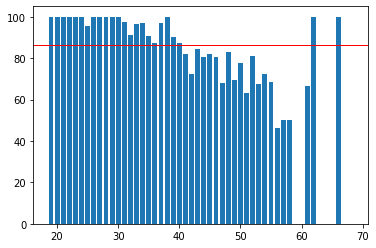

In [11]:
plt.bar(x=list(sorted_fg_perc_dict.keys()), height=list(sorted_fg_perc_dict.values()))
plt.axhline(y=basic_average, linewidth=1, color='r')
None

## Make a bet for each kick and see which teams would have made money
Need to figure out what to do if/when a distance has a success rate of 100% - currently has a payout of $0.00

Need to figure out what to do if/when a distance has a success rate of 0% - currently skipped over

**Idea - linear regression for line of best fit and use that line to create betting lines**

In [12]:
def team_ave_vs_league_ave(fg_dict, df):  
    # Use data dictionary to create new dictionary with key being fg distance, value being payout
    payout_dict = {}
    for elem in fg_dict:
        made = fg_dict[elem][1]
        missed = fg_dict[elem][0] - made
        wager = 10
        if(made > 0): # only have payouts for 
            payout = (missed/made)*wager
            payout_dict[elem] = payout   
    
    # create a dictionary of all teams where the value will be the team's betting profits/losses
    teams = list(df["team"].unique())
    team_dict = {}
    for i in range(len(teams)):
        team_dict[teams[i]] = 0
   
   # go through each row and make bets for each kick and add/subtract total from team's total
    for row in range(len(df)):
        # access list of made kicks
        made_kicks = df.loc[row, "fg_made_list"]  
        # if list is not empty
        if(str(df.loc[row, "fg_made_list"]) != "nan"):
            team = df.loc[row, "team"]
            for j in range(len(made_kicks)):
                team_dict[team] += payout_dict[int(made_kicks[j])]
    
        # access list of missed kicks
        missed_kicks = df.loc[row, "fg_missed_list"]  
        # if list is not empty
        if(str(df.loc[row, "fg_missed_list"]) != "nan"):
            team = df.loc[row, "team"]
            for j in range(len(missed_kicks)):
                team_dict[team] -= wager
            
    # round winnings
    for key in team_dict:
        team_dict[key] = round(team_dict[key], 2) 
        
    return(team_dict)

In [13]:
betting_dict = team_ave_vs_league_ave(data_dict, df)
betting_dict

{'ARI': -19.51,
 'ATL': 16.35,
 'BAL': 37.1,
 'BUF': -12.65,
 'CAR': 31.63,
 'CHI': 0.75,
 'CIN': 30.78,
 'CLE': -20.46,
 'DAL': -13.89,
 'DEN': 11.73,
 'DET': 0.0,
 'GB': -36.38,
 'HOU': -23.86,
 'IND': -14.17,
 'JAX': -26.17,
 'KC': 11.48,
 'LA': 13.6,
 'LAC': -6.38,
 'LV': 39.47,
 'MIA': -27.64,
 'MIN': 0.84,
 'NE': 20.57,
 'NO': -27.11,
 'NYG': 18.87,
 'PHI': 22.84,
 'PIT': 23.76,
 'SEA': -33.94,
 'SF': 9.45,
 'TB': -45.13,
 'TEN': -26.5,
 'WAS': 15.47,
 'NYJ': -30.91}

In [14]:
sorted_betting_dict = dict(sorted(betting_dict.items(), key=lambda item: item[1], reverse=True))
sorted_betting_dict

{'LV': 39.47,
 'BAL': 37.1,
 'CAR': 31.63,
 'CIN': 30.78,
 'PIT': 23.76,
 'PHI': 22.84,
 'NE': 20.57,
 'NYG': 18.87,
 'ATL': 16.35,
 'WAS': 15.47,
 'LA': 13.6,
 'DEN': 11.73,
 'KC': 11.48,
 'SF': 9.45,
 'MIN': 0.84,
 'CHI': 0.75,
 'DET': 0.0,
 'LAC': -6.38,
 'BUF': -12.65,
 'DAL': -13.89,
 'IND': -14.17,
 'ARI': -19.51,
 'CLE': -20.46,
 'HOU': -23.86,
 'JAX': -26.17,
 'TEN': -26.5,
 'NO': -27.11,
 'MIA': -27.64,
 'NYJ': -30.91,
 'SEA': -33.94,
 'GB': -36.38,
 'TB': -45.13}

In [15]:
sum(sorted_betting_dict.values())
# some kicks do not have any payouts, and some have never been made

-60.00999999999998

## Make a bet for each kick and see which kickers would have made money

In [16]:
def player_ave_vs_league_ave(fg_dict, df):  
    # Use data dictionary to create new dictionary with key being fg distance, value being payout
    payout_dict = {}
    for elem in fg_dict:
        made = fg_dict[elem][1]
        missed = fg_dict[elem][0] - made
        wager = 10
        if(made > 0): # only have payouts for 
            payout = (missed/made)*wager
            payout_dict[elem] = payout
    
    # create a dictionary of all teams where the value will be the team's betting profits/losses
    kickers = list(df["player_name"].unique())
    kickers_dict = {}
    for i in range(len(kickers)):
        kickers_dict[kickers[i]] = 0
    
   
   # go through each row and make bets for each kick and add/subtract total from team's total
    for row in range(len(df)):
        # access list of made kicks
        made_kicks = df.loc[row, "fg_made_list"]  
        # if list is not empty
        if(str(df.loc[row, "fg_made_list"]) != "nan"):
            player = df.loc[row, "player_name"]
            for j in range(len(made_kicks)):
                kickers_dict[player] += payout_dict[int(made_kicks[j])]
    
        # access list of missed kicks
        missed_kicks = df.loc[row, "fg_missed_list"]  
        # if list is not empty
        if(str(df.loc[row, "fg_missed_list"]) != "nan"):
            player = df.loc[row, "player_name"]
            for j in range(len(missed_kicks)):
                kickers_dict[player] -= wager
            
    # round winnings
    for key in kickers_dict:
        kickers_dict[key] = round(kickers_dict[key], 2) 
        
    return(kickers_dict)

In [17]:
player_betting_dict = player_ave_vs_league_ave(data_dict, df)
player_betting_dict

{'M.Prater': -19.51,
 'Y.Koo': 16.35,
 'J.Tucker': 37.1,
 'T.Bass': -12.65,
 'R.Santoso': -8.97,
 'C.Santos': 0.75,
 'E.McPherson': 29.31,
 'C.McLaughlin': -20.76,
 'G.Zuerlein': -13.89,
 'B.McManus': 11.73,
 'A.Seibert': -0.43,
 'M.Crosby': -36.38,
 'J.Slye': 20.44,
 'R.Blankenship': -8.4,
 'J.Lambo': -30,
 'H.Butker': 18.78,
 'M.Gay': 13.6,
 'T.Vizcaino': -6.24,
 'D.Carlson': 39.47,
 'J.Sanders': -27.64,
 'G.Joseph': 0.84,
 'N.Folk': 20.57,
 'A.Rosas': -25.8,
 'G.Gano': 18.87,
 'J.Elliott': 22.84,
 'C.Boswell': 23.76,
 'J.Myers': -33.94,
 'R.Gould': 7.41,
 'R.Succop': -35.13,
 'M.Badgley': -15.76,
 'D.Hopkins': -2.92,
 'Z.Gonzalez': 39.65,
 'M.Ammendola': -50.25,
 'R.Bullock': -16.5,
 'M.Wright': 3.83,
 'M.Wishnowsky': -10,
 'K.Fairbairn': -16.82,
 'C.Parkey': 0,
 'B.Pinion': -10,
 'B.Johnson': 6.85,
 'C.Blewitt': 4.51,
 'L.Hajrullahu': -8.01,
 'B.Maher': -4.27,
 'R.Patterson': 7.58,
 'A.Kessman': 0,
 'E.Pineiro': 19.34,
 'C.Naggar': 0.3,
 'D.Eberle': -3.76,
 'E.Fry': -5.83}

In [18]:
sorted_player_betting_dict = dict(sorted(player_betting_dict.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict

{'Z.Gonzalez': 39.65,
 'D.Carlson': 39.47,
 'J.Tucker': 37.1,
 'E.McPherson': 29.31,
 'C.Boswell': 23.76,
 'J.Elliott': 22.84,
 'N.Folk': 20.57,
 'J.Slye': 20.44,
 'E.Pineiro': 19.34,
 'G.Gano': 18.87,
 'H.Butker': 18.78,
 'Y.Koo': 16.35,
 'M.Gay': 13.6,
 'B.McManus': 11.73,
 'R.Patterson': 7.58,
 'R.Gould': 7.41,
 'B.Johnson': 6.85,
 'C.Blewitt': 4.51,
 'M.Wright': 3.83,
 'G.Joseph': 0.84,
 'C.Santos': 0.75,
 'C.Naggar': 0.3,
 'C.Parkey': 0,
 'A.Kessman': 0,
 'A.Seibert': -0.43,
 'D.Hopkins': -2.92,
 'D.Eberle': -3.76,
 'B.Maher': -4.27,
 'E.Fry': -5.83,
 'T.Vizcaino': -6.24,
 'L.Hajrullahu': -8.01,
 'R.Blankenship': -8.4,
 'R.Santoso': -8.97,
 'M.Wishnowsky': -10,
 'B.Pinion': -10,
 'T.Bass': -12.65,
 'G.Zuerlein': -13.89,
 'M.Badgley': -15.76,
 'R.Bullock': -16.5,
 'K.Fairbairn': -16.82,
 'M.Prater': -19.51,
 'C.McLaughlin': -20.76,
 'A.Rosas': -25.8,
 'J.Sanders': -27.64,
 'J.Lambo': -30,
 'J.Myers': -33.94,
 'R.Succop': -35.13,
 'M.Crosby': -36.38,
 'M.Ammendola': -50.25}

### Divide payout by number of attempted kicks

In [19]:
player_betting_dict_per_kick = {}
for player in player_betting_dict.keys():
    player_df = df[df["player_name"] == player]
    player_df.reset_index(drop=False, inplace=True)
    #print(f"Length of player df: {len(player_df)}")
    kicks = 0
    for i in range(len(player_df)):
        made = len(player_df.loc[i, "fg_made_list"])
        missed = len(player_df.loc[i, "fg_missed_list"])
        kicks += made + missed
    
    if(kicks > 0):
        player_betting_dict_per_kick[player] = round(player_betting_dict[player]/kicks, 2)

sorted_player_betting_dict_per_kick = dict(sorted(player_betting_dict_per_kick.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict_per_kick

{'E.Pineiro': 2.42,
 'C.Blewitt': 2.25,
 'Z.Gonzalez': 1.89,
 'J.Tucker': 1.0,
 'D.Carlson': 0.84,
 'J.Slye': 0.82,
 'J.Elliott': 0.71,
 'B.Johnson': 0.68,
 'E.McPherson': 0.65,
 'C.Boswell': 0.59,
 'H.Butker': 0.57,
 'G.Gano': 0.57,
 'Y.Koo': 0.56,
 'R.Patterson': 0.54,
 'N.Folk': 0.51,
 'B.McManus': 0.39,
 'M.Gay': 0.32,
 'C.Naggar': 0.3,
 'R.Gould': 0.26,
 'M.Wright': 0.16,
 'C.Santos': 0.03,
 'G.Joseph': 0.02,
 'A.Seibert': -0.04,
 'D.Hopkins': -0.09,
 'B.Maher': -0.24,
 'G.Zuerlein': -0.39,
 'T.Bass': -0.4,
 'M.Prater': -0.51,
 'R.Bullock': -0.52,
 'R.Blankenship': -0.65,
 'M.Badgley': -0.72,
 'T.Vizcaino': -0.89,
 'K.Fairbairn': -0.89,
 'J.Sanders': -0.95,
 'R.Succop': -1.03,
 'C.McLaughlin': -1.04,
 'M.Crosby': -1.1,
 'E.Fry': -1.17,
 'D.Eberle': -1.25,
 'J.Myers': -1.48,
 'L.Hajrullahu': -1.6,
 'R.Santoso': -1.79,
 'M.Ammendola': -2.64,
 'A.Rosas': -5.16,
 'J.Lambo': -10.0,
 'M.Wishnowsky': -10.0,
 'B.Pinion': -10.0}

## set minimum attempts to 10

In [20]:
player_betting_dict_per_kick = {}
for player in player_betting_dict.keys():
    player_df = df[df["player_name"] == player]
    player_df.reset_index(drop=False, inplace=True)
    #print(f"Length of player df: {len(player_df)}")
    kicks = 0
    for i in range(len(player_df)):
        made = len(player_df.loc[i, "fg_made_list"])
        missed = len(player_df.loc[i, "fg_missed_list"])
        kicks += made + missed
    
    if(kicks > 10):
        player_betting_dict_per_kick[player] = round(player_betting_dict[player]/kicks, 2)

sorted_player_betting_dict_per_kick = dict(sorted(player_betting_dict_per_kick.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict_per_kick

{'Z.Gonzalez': 1.89,
 'J.Tucker': 1.0,
 'D.Carlson': 0.84,
 'J.Slye': 0.82,
 'J.Elliott': 0.71,
 'E.McPherson': 0.65,
 'C.Boswell': 0.59,
 'H.Butker': 0.57,
 'G.Gano': 0.57,
 'Y.Koo': 0.56,
 'R.Patterson': 0.54,
 'N.Folk': 0.51,
 'B.McManus': 0.39,
 'M.Gay': 0.32,
 'R.Gould': 0.26,
 'M.Wright': 0.16,
 'C.Santos': 0.03,
 'G.Joseph': 0.02,
 'A.Seibert': -0.04,
 'D.Hopkins': -0.09,
 'B.Maher': -0.24,
 'G.Zuerlein': -0.39,
 'T.Bass': -0.4,
 'M.Prater': -0.51,
 'R.Bullock': -0.52,
 'R.Blankenship': -0.65,
 'M.Badgley': -0.72,
 'K.Fairbairn': -0.89,
 'J.Sanders': -0.95,
 'R.Succop': -1.03,
 'C.McLaughlin': -1.04,
 'M.Crosby': -1.1,
 'J.Myers': -1.48,
 'M.Ammendola': -2.64}